In [54]:
# import necessary libraries
library(caret) # for data partition
library(doParallel)

In [55]:
registerDoParallel(makeCluster(detectCores()))

In [56]:
# INPUT: 43958 labeled , 4884 unlabeled
dataIN <- as.matrix(read.csv('train.data', header = F)[ ,c(1,3,5,11,12,13,15)])
dataTest <- as.matrix(read.csv('test.data', header = F)[ ,c(1,3,5,11,12,13)])

In [57]:
# use label c(1,-1) instead of c('>50K', '<=50K')
dataIN[dataIN[,7] == dataIN[1,7],7]  <- -1
dataIN[dataIN[,7] != dataIN[1,7],7]  <- 1
# data partition, split it randomly into 10% validation and 90% training data
trainRange <- createDataPartition(y = dataIN[,7], p = .9, list = F)
dataTrain <- dataIN[trainRange, ]
dataVal <- dataIN[-trainRange, ]
# divide features and labels
dataTrain.feature <- dataTrain[,-c(7)]
dataTrain.label <- dataTrain[,c(7)]
dataVal.feature <- dataVal[,-c(7)]
dataVal.label <- dataVal[,c(7)]
# scale the data with zero mean and unit variance
for (j in 1:6){
    dataTrain.feature[,j] <- scale(as.numeric(dataTrain.feature[,j]))
    dataVal.feature[,j] <- scale(as.numeric(dataVal.feature[,j]))
    dataTest[,j] <- scale(as.numeric(dataTest[,j]))
}

In [325]:
# Initialization of Parameters for training
lambdaAttempts <- c(1e-3, 1e-2, 1e-1, 1, 5e-3, 2.5e-3, 1.25e-3)
NATTEMPT <- length(lambdaAttempts)
NEPOCH <- 50
NSTEP <- 300
accuracy <- matrix(0, NATTEMPT, NEPOCH*NSTEP/30)
magnitude <- matrix(0, NATTEMPT, NEPOCH*NSTEP/30)
# to store best A and B for each lambda
bestAccuracy <- 0.5
bestLambda <- 0
bestA <- matrix(0, NATTEMPT, 6)
bestB <- matrix(0, NATTEMPT, )

In [335]:
# Initialization of Parameters for training
lambdaAttempts <- c(1e-3, 5e-3, 2.5e-3, 1.25e-3)
NATTEMPT <- length(lambdaAttempts)
NEPOCH <- 100
NSTEP <- 600
accuracy <- matrix(0, NATTEMPT, NEPOCH*NSTEP/30)
magnitude <- matrix(0, NATTEMPT, NEPOCH*NSTEP/30)
# to store best A and B for each lambda
bestAccuracy <- 0.5
bestLambda <- 0
bestA <- matrix(0, NATTEMPT, 6)
bestB <- matrix(0, NATTEMPT, )

In [326]:
# train
while (bestAccuracy<0.82){
for (i in 1:NATTEMPT){
    lambda <- lambdaAttempts[i]
    A <- runif(6,0.0,0.5)
    B <- runif(1,0.0,0.5)
    for (epoch in 1:NEPOCH){
        heldout <- sample(1:nrow(dataTrain), 50, replace = F)
        train <- setdiff(c(1:nrow(dataTrain)), heldout)
        stepSize <- runif(1,1,10) / (0.01 * epoch + runif(1,25,100))
        for (step in 1:NSTEP){
            batch <- sample(train, 1)
            X <- as.double(dataTrain.feature[batch,])
            score <- as.double((t(A)%*%X) + B) * as.double(dataTrain.label[batch])
            if (score >= 1){
                A <- A - A * lambda * stepSize
            } else {
                A <- A - (A * lambda - X * as.double(dataTrain.label[batch])) * stepSize
                B <- B + stepSize * as.double(dataTrain.label[batch])
            }
            if (step %% 30 == 0){
                correct <- 0
                for (j in heldout){
                    product <- A%*%as.double(dataTrain.feature[j,]) + B
                    if (product * as.double(dataTrain.label[j]) > 0){
                        correct <- correct + 1
                    }
                }
                accuracy[i,(epoch-1)*NSTEP/30+step/30] <- correct/50
                magnitude[i,(epoch-1)*NSTEP/30+step/30] <- sqrt(sum(A^2))
            }
        }
    }
    correct <- 0
    for (j in 1:nrow(dataVal)){
        product <- A%*%as.double(dataVal.feature[j,]) + B
        if (product * as.double(dataVal.label[j]) > 0){
            correct <- correct + 1
        }
    }
    if (correct/nrow(dataVal)>bestAccuracy){
        bestAccuracy <- correct/nrow(dataVal)
        bestA <- A
        bestB <- B
        bestLambda <- lambda
    }
#      print(correct/nrow(dataVal))
}
}
print(bestAccuracy)
print(bestLambda)

In [338]:
# train
while (bestAccuracy<0.825){
for (i in 1:NATTEMPT){
    lambda <- lambdaAttempts[i]
    A <- runif(6,0.0,0.5)
    B <- runif(1,0.0,0.5)
    for (epoch in 1:NEPOCH){
        heldout <- sample(1:nrow(dataTrain), 50, replace = F)
        train <- setdiff(c(1:nrow(dataTrain)), heldout)
        stepSize <- 2 / (0.01 * epoch + 100)
        for (step in 1:NSTEP){
            batch <- sample(train, 1)
            X <- as.double(dataTrain.feature[batch,])
            score <- as.double((t(A)%*%X) + B) * as.double(dataTrain.label[batch])
            if (score >= 1){
                A <- A - A * lambda * stepSize
            } else {
                A <- A - (A * lambda - X * as.double(dataTrain.label[batch])) * stepSize
                B <- B + stepSize * as.double(dataTrain.label[batch])
            }
            if (step %% 30 == 0){
                correct <- 0
                for (j in heldout){
                    product <- A%*%as.double(dataTrain.feature[j,]) + B
                    if (product * as.double(dataTrain.label[j]) > 0){
                        correct <- correct + 1
                    }
                }
                accuracy[i,(epoch-1)*NSTEP/30+step/30] <- correct/50
                magnitude[i,(epoch-1)*NSTEP/30+step/30] <- sqrt(sum(A^2))
            }
        }
    }
    correct <- 0
    for (j in 1:nrow(dataVal)){
        product <- A%*%as.double(dataVal.feature[j,]) + B
        if (product * as.double(dataVal.label[j]) > 0){
            correct <- correct + 1
        }
    }
    if (correct/nrow(dataVal)>bestAccuracy){
        bestAccuracy <- correct/nrow(dataVal)
        bestA <- A
        bestB <- B
        bestLambda <- lambda
    }
#      print(correct/nrow(dataVal))
}
}
print(bestAccuracy)
print(bestLambda)

## Plot accuracy/magnitude of the coefficient vector every 30 steps

Warning message in title(...):
“conversion failure on 'Accuracy for Each λ (Every 30 Steps)' in 'mbcsToSbcs': dot substituted for <ce>”Warning message in title(...):
“conversion failure on 'Accuracy for Each λ (Every 30 Steps)' in 'mbcsToSbcs': dot substituted for <bb>”Warning message in strwidth(title, units = "user", cex = cex):
“conversion failure on 'λ' in 'mbcsToSbcs': dot substituted for <ce>”Warning message in strwidth(title, units = "user", cex = cex):
“conversion failure on 'λ' in 'mbcsToSbcs': dot substituted for <bb>”Warning message in text.default(x, y, ...):
“conversion failure on 'λ' in 'mbcsToSbcs': dot substituted for <ce>”Warning message in text.default(x, y, ...):
“conversion failure on 'λ' in 'mbcsToSbcs': dot substituted for <bb>”

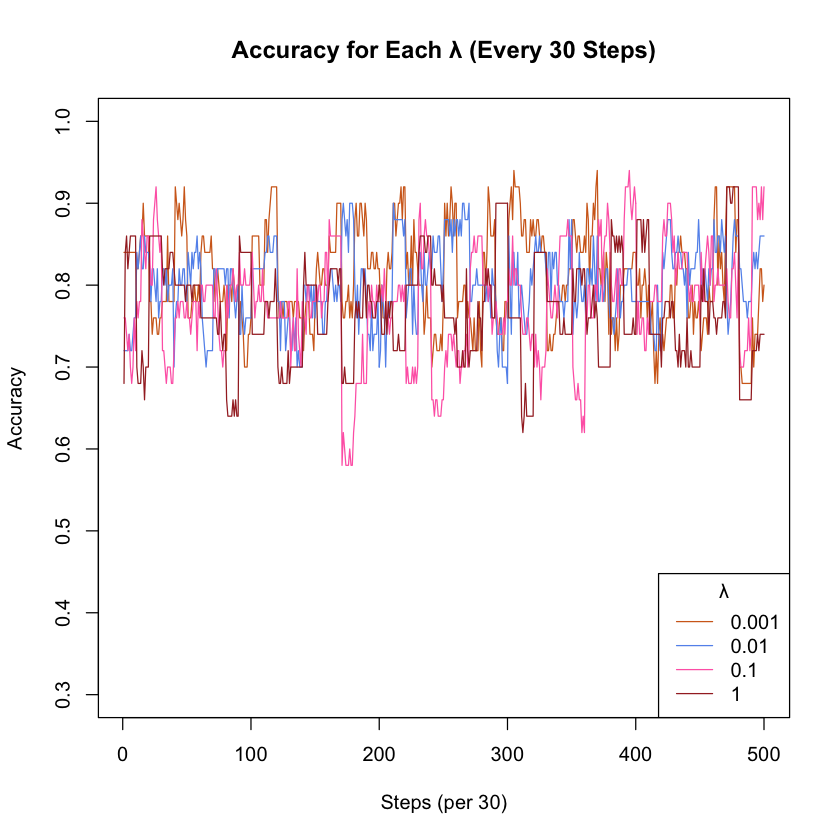

In [177]:
X = 1:(NEPOCH*NSTEP/30)
plot(X, accuracy[1, ], main = "Accuracy for Each \u03BB (Every 30 Steps)", xlab = "Steps (per 30)", ylab = "Accuracy", ylim = c(0.3,1), type = 'l', col = "chocolate")
lines(X, accuracy[2, ], col = "cornflowerblue")
lines(X, accuracy[3, ], col = "hotpink")
lines(X, accuracy[4, ], col = "brown")
legend("bottomright", legend = lambdaAttempts[1:4], col = c("chocolate", "cornflowerblue", "hotpink", "brown"), lty = 1, title = "\u03BB")

Warning message in title(...):
“conversion failure on 'Magnitude of a for Each λ (Every 30 Steps)' in 'mbcsToSbcs': dot substituted for <ce>”Warning message in title(...):
“conversion failure on 'Magnitude of a for Each λ (Every 30 Steps)' in 'mbcsToSbcs': dot substituted for <bb>”Warning message in strwidth(title, units = "user", cex = cex):
“conversion failure on 'λ' in 'mbcsToSbcs': dot substituted for <ce>”Warning message in strwidth(title, units = "user", cex = cex):
“conversion failure on 'λ' in 'mbcsToSbcs': dot substituted for <bb>”Warning message in text.default(x, y, ...):
“conversion failure on 'λ' in 'mbcsToSbcs': dot substituted for <ce>”Warning message in text.default(x, y, ...):
“conversion failure on 'λ' in 'mbcsToSbcs': dot substituted for <bb>”

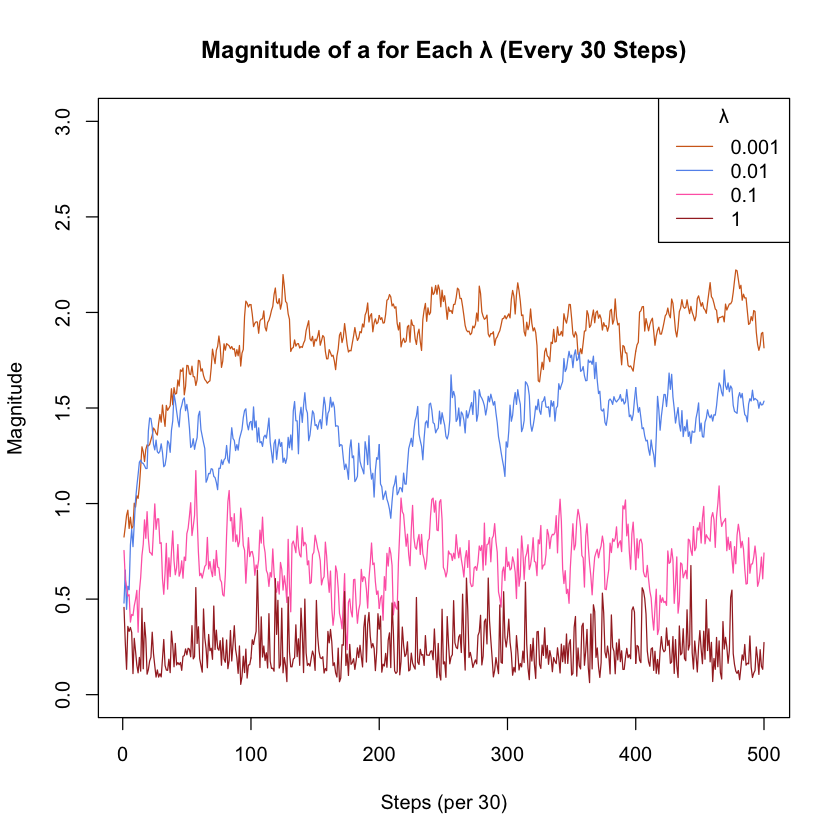

In [179]:
plot(X, magnitude[1, ], main = "Magnitude of a for Each \u03BB (Every 30 Steps)", xlab = "Steps (per 30)", ylab = "Magnitude", ylim = c(0,3), type = 'l', col = "chocolate")
lines(X, magnitude[2, ], col = "cornflowerblue")
lines(X, magnitude[3, ], col = "hotpink")
lines(X, magnitude[4, ], col = "brown")
legend("topright", legend = lambdaAttempts[1:4], col = c("chocolate", "cornflowerblue", "hotpink", "brown"), lty = 1, title = "\u03BB")

## Make Predictions on the Test Data

In [340]:
pred <- rep('<=50K',nrow(dataTest))
for (i in 1:nrow(dataTest)){
    product <- bestA%*%as.double(dataTest[i,]) + bestB
    if (product > 0){
        pred[i] <- '>50K'
    }
}

In [341]:
# print to csv file
output = data.frame(Example = as.matrix(as.character(0:(nrow(dataTest)-1))), Label = as.matrix(pred))
write.csv(output, file = "chaox2.csv", quote = c(1), row.names = F)
# for submission, double quotes should be replaced by single quotes manually

In [339]:
bestAccuracy

[1] 0.8204778